# Autoencoder  
in outlier detection (NOT COMPLETE)

In [6]:
import tensorflow as tf
from tensorflow.keras.datasets import mnist
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras import layers,models
import pandas as pd

In [7]:
df_art_daily_jumpsup = pd.read_csv('art_daily_jumpsup.csv')
df_art_daily_jumpsup

,timestamp,value
0,2014-04-01 00:00:00,19.761252
1,2014-04-01 00:05:00,20.500833
2,2014-04-01 00:10:00,19.961641
3,2014-04-01 00:15:00,21.490266
4,2014-04-01 00:20:00,20.187739
...,...,...
4027,2014-04-14 23:35:00,18.074649
4028,2014-04-14 23:40:00,21.002014
4029,2014-04-14 23:45:00,20.566713
4030,2014-04-14 23:50:00,18.254193


In [8]:
df_small_noise = pd.read_csv('art_daily_small_noise.csv')
df_small_noise

,timestamp,value
0,2014-04-01 00:00:00,18.324919
1,2014-04-01 00:05:00,21.970327
2,2014-04-01 00:10:00,18.624806
3,2014-04-01 00:15:00,21.953684
4,2014-04-01 00:20:00,21.909120
...,...,...
4027,2014-04-14 23:35:00,20.211195
4028,2014-04-14 23:40:00,20.531041
4029,2014-04-14 23:45:00,19.032127
4030,2014-04-14 23:50:00,21.798801


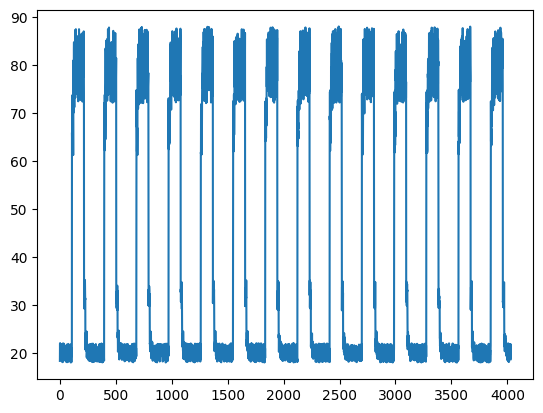

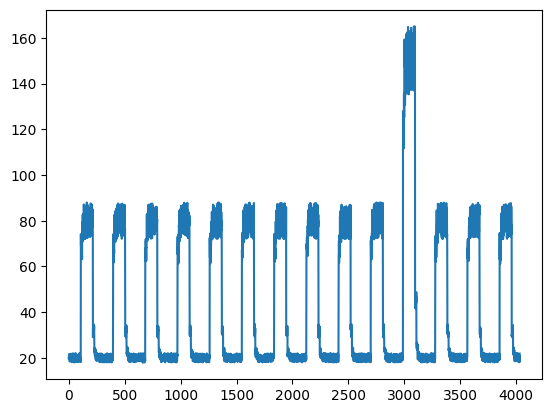

In [9]:
def plot_dataframe(df,title):
    fig,ax = plt.subplots()
    df.plot(legend=False,ax=ax)
    plt.show()

plot_dataframe(df_small_noise,"small noise 'Data")
plot_dataframe(df_art_daily_jumpsup,"daily jumps up Data")

In [10]:
training_mean =  df_small_noise['value'].mean()
training_std = df_small_noise['value'].std()
df_training_value = (df_small_noise['value']- training_mean)/training_std

In [11]:
default = 288 # هر روز 288 تا 5 دقیقه دارد
def create_sequences(data , time_steps=default):
    sequences = []
    for start_idx in range(len(data) - time_steps +1):
        end_idx = start_idx + time_steps
        sequences.append(data[end_idx:start_idx])
    return np.stack(sequences)
training_data = df_training_value.values
xtrain = create_sequences(training_data)
xtrain.shape

(3745, 0)

In [12]:
import numpy as np
import tensorflow as tf

if len(xtrain.shape) == 2:
    xtrain = np.expand_dims(xtrain, axis=-1)

model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(xtrain.shape[1], xtrain.shape[2])),
    
    tf.keras.layers.Conv1D(
        filters=32, kernel_size=7, padding='same',
        strides=2, activation='relu'
    ),
    tf.keras.layers.Dropout(rate=0.2),

    tf.keras.layers.Conv1D(
        filters=16, kernel_size=7, padding='same',
        strides=2, activation='relu'
    ),

    tf.keras.layers.Conv1DTranspose(
        filters=16, kernel_size=7, padding='same',
        strides=2, activation='relu'
    ),
    tf.keras.layers.Dropout(rate=0.2),

    tf.keras.layers.Conv1DTranspose(
        filters=32, kernel_size=7, padding='same',
        strides=2, activation='relu'
    ),
    tf.keras.layers.Conv1DTranspose(
        filters=1, kernel_size=7, padding='same'
    ),
])

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='mse'
)

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                      │ (None, 0, 32)               │             256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 0, 32)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_1 (Conv1D)                    │ (None, 0, 16)               │           3,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_transpose (Conv1DTranspose)   │ (None, 0, 16)               │           1,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 0, 16)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_transpose_1 (Conv1DTranspose) │ (None, 0, 32)               │           3,616 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_transpose_2 (Conv1DTranspose) │ (None, 0, 1)                │             225 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 9,505 (37.13 KB)

 Trainable params: 9,505 (37.13 KB)

 Non-trainable params: 0 (0.00 B)

In [13]:
history  = model.fit(
    xtrain,
    xtrain,
    epochs=50 ,
    batch_size=128,
    validation_split= 0.1,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(monitor = "val_loss",patience = 5,mode = "min")
    ]
)

Epoch 1/50


InvalidArgumentError: Graph execution error:

Detected at node sequential_1/conv1d_1/BiasAdd defined at (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main

  File "<frozen runpy>", line 88, in _run_code

  File "C:\Users\ofogh\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\ipykernel_launcher.py", line 18, in <module>

  File "C:\Users\ofogh\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\traitlets\config\application.py", line 1075, in launch_instance

  File "C:\Users\ofogh\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\ipykernel\kernelapp.py", line 739, in start

  File "C:\Users\ofogh\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\tornado\platform\asyncio.py", line 205, in start

  File "C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.13_3.13.2032.0_x64__qbz5n2kfra8p0\Lib\asyncio\base_events.py", line 683, in run_forever

  File "C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.13_3.13.2032.0_x64__qbz5n2kfra8p0\Lib\asyncio\base_events.py", line 2050, in _run_once

  File "C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.13_3.13.2032.0_x64__qbz5n2kfra8p0\Lib\asyncio\events.py", line 89, in _run

  File "C:\Users\ofogh\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\ipykernel\kernelbase.py", line 545, in dispatch_queue

  File "C:\Users\ofogh\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\ipykernel\kernelbase.py", line 534, in process_one

  File "C:\Users\ofogh\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\ipykernel\kernelbase.py", line 437, in dispatch_shell

  File "C:\Users\ofogh\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\ipykernel\ipkernel.py", line 362, in execute_request

  File "C:\Users\ofogh\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\ipykernel\kernelbase.py", line 778, in execute_request

  File "C:\Users\ofogh\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\ipykernel\ipkernel.py", line 449, in do_execute

  File "C:\Users\ofogh\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\ipykernel\zmqshell.py", line 549, in run_cell

  File "C:\Users\ofogh\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\IPython\core\interactiveshell.py", line 3116, in run_cell

  File "C:\Users\ofogh\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\IPython\core\interactiveshell.py", line 3171, in _run_cell

  File "C:\Users\ofogh\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\IPython\core\async_helpers.py", line 128, in _pseudo_sync_runner

  File "C:\Users\ofogh\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\IPython\core\interactiveshell.py", line 3394, in run_cell_async

  File "C:\Users\ofogh\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\IPython\core\interactiveshell.py", line 3639, in run_ast_nodes

  File "C:\Users\ofogh\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\IPython\core\interactiveshell.py", line 3699, in run_code

  File "C:\Users\ofogh\AppData\Local\Temp\ipykernel_6708\1720124173.py", line 1, in <module>

  File "C:\Users\ofogh\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\keras\src\utils\traceback_utils.py", line 117, in error_handler

  File "C:\Users\ofogh\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\keras\src\backend\tensorflow\trainer.py", line 377, in fit

  File "C:\Users\ofogh\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\keras\src\backend\tensorflow\trainer.py", line 220, in function

  File "C:\Users\ofogh\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\keras\src\backend\tensorflow\trainer.py", line 133, in multi_step_on_iterator

  File "C:\Users\ofogh\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\keras\src\backend\tensorflow\trainer.py", line 114, in one_step_on_data

  File "C:\Users\ofogh\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\keras\src\backend\tensorflow\trainer.py", line 58, in train_step

  File "C:\Users\ofogh\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\keras\src\utils\traceback_utils.py", line 117, in error_handler

  File "C:\Users\ofogh\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\keras\src\layers\layer.py", line 941, in __call__

  File "C:\Users\ofogh\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\keras\src\utils\traceback_utils.py", line 117, in error_handler

  File "C:\Users\ofogh\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\keras\src\ops\operation.py", line 59, in __call__

  File "C:\Users\ofogh\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\keras\src\utils\traceback_utils.py", line 156, in error_handler

  File "C:\Users\ofogh\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\keras\src\models\sequential.py", line 220, in call

  File "C:\Users\ofogh\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\keras\src\models\functional.py", line 183, in call

  File "C:\Users\ofogh\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\keras\src\ops\function.py", line 206, in _run_through_graph

  File "C:\Users\ofogh\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\keras\src\models\functional.py", line 644, in call

  File "C:\Users\ofogh\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\keras\src\utils\traceback_utils.py", line 117, in error_handler

  File "C:\Users\ofogh\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\keras\src\layers\layer.py", line 941, in __call__

  File "C:\Users\ofogh\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\keras\src\utils\traceback_utils.py", line 117, in error_handler

  File "C:\Users\ofogh\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\keras\src\ops\operation.py", line 59, in __call__

  File "C:\Users\ofogh\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\keras\src\utils\traceback_utils.py", line 156, in error_handler

  File "C:\Users\ofogh\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\keras\src\layers\convolutional\conv1d.py", line 166, in call

  File "C:\Users\ofogh\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\keras\src\ops\numpy.py", line 237, in add

  File "C:\Users\ofogh\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\keras\src\backend\tensorflow\sparse.py", line 493, in sparse_wrapper

  File "C:\Users\ofogh\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\keras\src\backend\tensorflow\numpy.py", line 129, in add

Must provide as many biases as the last dimension of the input tensor: [32] vs. [128,0,1]
	 [[{{node sequential_1/conv1d_1/BiasAdd}}]] [Op:__inference_multi_step_on_iterator_2256]

In [14]:
print("xtrain.shape:", xtrain.shape)

xtrain.shape: (3745, 0, 1)


In [ ]:
# راه حل نهایی: کاهش ابعاد داده‌ها
print("Reducing data size for debugging...")

# استفاده از subset کوچک‌تر از داده‌ها
sample_size = min(1000, xtrain.shape[0])
xtrain_small = xtrain[:sample_size]

print(f"Using small subset: {xtrain_small.shape}")

# مدل بسیار ساده
model_simple = tf.keras.Sequential([
    layers.Input(shape=(xtrain_small.shape[1], xtrain_small.shape[2])),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(xtrain_small.shape[1] * xtrain_small.shape[2], activation='sigmoid'),
    layers.Reshape((xtrain_small.shape[1], xtrain_small.shape[2]))
])

model_simple.compile(optimizer='adam', loss='mse')

# آموزش با داده‌های کوچک
history = model_simple.fit(
    xtrain_small,
    xtrain_small,
    epochs=20,
    batch_size=32,
    validation_split=0.2,
    verbose=1
)

Reducing data size for debugging...
Using small subset: (1000, 0, 1)
Epoch 1/20
